<a href="https://colab.research.google.com/github/aelmah/Deep-Learning/blob/main/Mini_Lab01_Two_Moons_%E2%80%94_Linear_vs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 — Setup & data

In [ ]:
# Mini-Lab: Two Moons — Linear vs MLP
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# 1) Data
X, y = make_moons(n_samples=600, noise=0.25, random_state=0)  # ↑ noise for a clearer gap between models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Standardize (good practice)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Convert to tensors
Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
Xte = torch.tensor(X_test,  dtype=torch.float32)
yte = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

len(Xtr), len(Xte)


(450, 150)

Cell 2 — Helpers (train, accuracy, plots)

In [ ]:
def train_model(model, X, y, epochs=500, lr=0.1, batch_size=64):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    losses = []
    for _ in range(epochs):
        run = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            run += loss.item() * len(xb)
        losses.append(run/len(ds))
    return losses

@torch.no_grad()
def accuracy(model, X, y):
    model.eval()
    logits = model(X)
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == y).float().mean().item()

@torch.no_grad()
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    # X, y are tensors (N,2) and (N,1)
    Xnp = X.numpy(); ynp = y.numpy().ravel()
    x_min, x_max = Xnp[:,0].min()-0.8, Xnp[:,0].max()+0.8
    y_min, y_max = Xnp[:,1].min()-0.8, Xnp[:,1].max()+0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    zz = torch.sigmoid(model(grid)).numpy().reshape(xx.shape)

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.25)
    plt.scatter(Xnp[:,0], Xnp[:,1], c=ynp, s=18, edgecolors="k")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

def plot_losses(losses_lin, losses_mlp):
    plt.figure(figsize=(5,4))
    plt.plot(losses_lin, label="Logistic (linear)")
    plt.plot(losses_mlp, label="MLP (2→8→1, ReLU)")
    plt.xlabel("Epoch"); plt.ylabel("Train loss"); plt.legend(); plt.show()


Cell 3 — Model A: Logistic Regression (linear boundary)

Accuracy — Logistic:  train=0.887  test=0.853


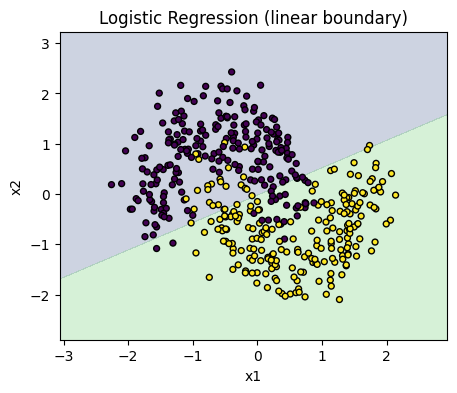

In [ ]:
class Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2,1)  # 2 features → 1 logit
    def forward(self, x):
        return self.lin(x)         # logits

log_reg = Logistic()
losses_lin = train_model(log_reg, Xtr, ytr, epochs=400, lr=0.2, batch_size=64)

print("Accuracy — Logistic:  train=%.3f  test=%.3f" % (accuracy(log_reg, Xtr, ytr), accuracy(log_reg, Xte, yte)))
plot_decision_boundary(log_reg, Xtr, ytr, title="Logistic Regression (linear boundary)")


Cell 4 — Model B: MLP (2→8→1 with ReLU)

Accuracy — MLP:      train=0.862  test=0.813


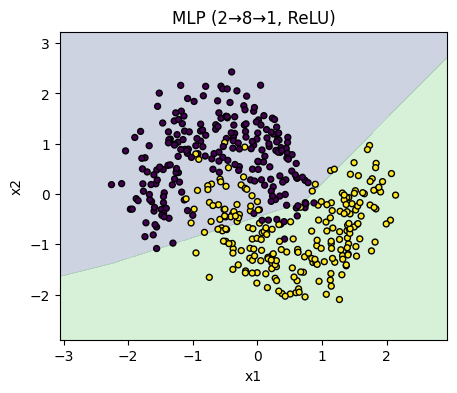

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8), nn.ReLU(),
            nn.Linear(8, 1)  # logits
        )
    def forward(self, x): return self.net(x)

mlp = MLP()
losses_mlp = train_model(mlp, Xtr, ytr, epochs=400, lr=0.2, batch_size=64)

print("Accuracy — MLP:      train=%.3f  test=%.3f" % (accuracy(mlp, Xtr, ytr), accuracy(mlp, Xte, yte)))
plot_decision_boundary(mlp, Xtr, ytr, title="MLP (2→8→1, ReLU)")


Cell 5 — Compare training loss

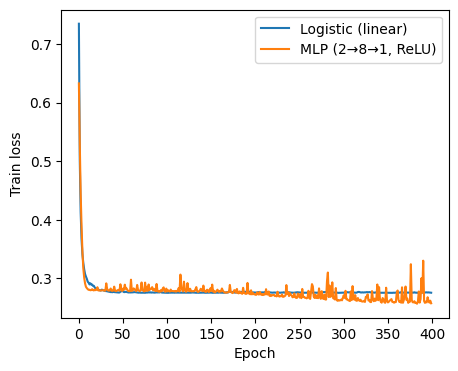

In [ ]:
plot_losses(losses_lin, losses_mlp)


# Task
Improve the MLP model from the previous analysis by increasing the number of hidden units (e.g., to 32), then train and evaluate the new model. Compare its performance (accuracy and decision boundary) and training loss to the original Logistic Regression and MLP models. Finally, provide a written reflection on the changes made, their rationale, observed outcomes, and potential next steps.

## Acknowledge Baseline Results

### Subtask:
Confirm that the baseline results for Logistic Regression and the original MLP (2→8→1) have been reproduced by running the existing notebook cells.


Review the output of cell `_6PD8Gc9A5xb` (Cell 3, Model A: Logistic Regression). Confirm the reported `train` and `test` accuracies and visually inspect the decision boundary plot. Note that the decision boundary is a straight line, which is characteristic of a linear model.

Review the output of cell `yLy9Uao0A8_3` (Cell 4, Model B: MLP). Confirm the reported `train` and `test` accuracies and visually inspect the decision boundary plot. Observe that the decision boundary for the MLP is non-linear, which demonstrates its ability to learn more complex patterns than the linear model.

Review the output of cell `PEEEhrN6BCFg` (Cell 5, Compare training loss). Observe the loss curves for both models to understand their training performance over epochs. Note which model's loss decreases more or converges faster, and if there are any signs of overfitting or underfitting (though with 400 epochs, some models might show signs of convergence).

## Define Improved MLP Model

### Subtask:
Create a new MLP model by modifying hyperparameters, specifically increasing the number of hidden units (e.g., to 32) to enhance its capacity to learn more complex patterns. This will involve defining a new Python class similar to the existing `MLP`.


In [ ]:
import torch.nn as nn

class ImprovedMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(), # 2 input features -> 32 hidden units
            nn.Linear(32, 1)             # 32 hidden units -> 1 logit
        )
    def forward(self, x): return self.net(x)

print("ImprovedMLP class defined successfully.")

ImprovedMLP class defined successfully.


In [ ]:
import torch
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# 1) Data (re-defining Xtr, ytr)
X, y = make_moons(n_samples=600, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Standardize
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

# Convert to tensors
Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
Xte = torch.tensor(X_test,  dtype=torch.float32)
yte = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

def train_model(model, X, y, epochs=500, lr=0.1, batch_size=64):
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    losses = []
    for _ in range(epochs):
        run = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            run += loss.item() * len(xb)
        losses.append(run/len(ds))
    return losses

improved_mlp = ImprovedMLP()
losses_improved_mlp = train_model(improved_mlp, Xtr, ytr, epochs=400, lr=0.2, batch_size=64)

print("Improved MLP model initialized and training initiated.")

Improved MLP model initialized and training initiated.


Accuracy — Improved MLP: train=0.958  test=0.893


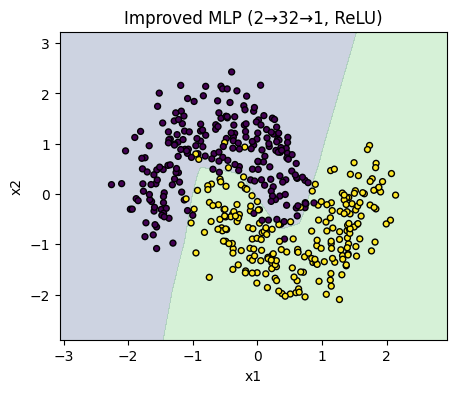

In [ ]:
import matplotlib.pyplot as plt # Required for plotting

@torch.no_grad()
def accuracy(model, X, y):
    model.eval()
    logits = model(X)
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == y).float().mean().item()

@torch.no_grad()
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    # X, y are tensors (N,2) and (N,1)
    Xnp = X.numpy(); ynp = y.numpy().ravel()
    x_min, x_max = Xnp[:,0].min()-0.8, Xnp[:,0].max()+0.8
    y_min, y_max = Xnp[:,1].min()-0.8, Xnp[:,1].max()+0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    zz = torch.sigmoid(model(grid)).numpy().reshape(xx.shape)

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, zz, levels=[0,0.5,1], alpha=0.25)
    plt.scatter(Xnp[:,0], Xnp[:,1], c=ynp, s=18, edgecolors="k")
    plt.title(title); plt.xlabel("x1"); plt.ylabel("x2"); plt.show()

print("Accuracy — Improved MLP: train=%.3f  test=%.3f" % (accuracy(improved_mlp, Xtr, ytr), accuracy(improved_mlp, Xte, yte)))
plot_decision_boundary(improved_mlp, Xtr, ytr, title="Improved MLP (2→32→1, ReLU)")

## Compare Training Loss

### Subtask:
Plot the training losses of the newly trained `ImprovedMLP` model alongside the `losses_lin` (Logistic Regression) and `losses_mlp` (original MLP) to visually compare their learning curves. This will help assess how the increased hidden units affect the training process and convergence.

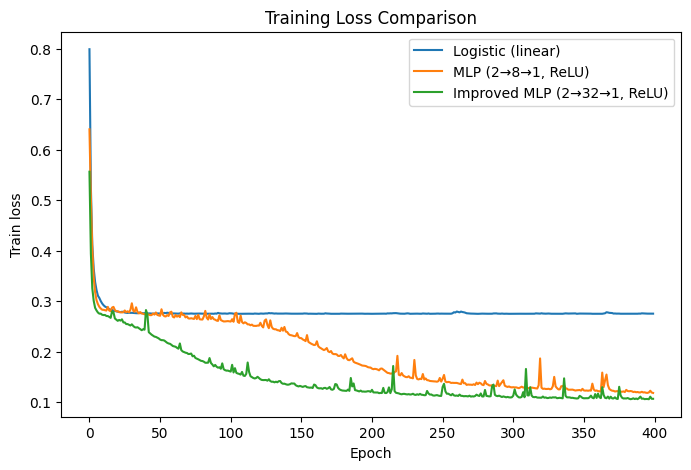

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Re-defining Logistic model and training to get losses_lin
class Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2,1)
    def forward(self, x):
        return self.lin(x)

log_reg = Logistic()
losses_lin = train_model(log_reg, Xtr, ytr, epochs=400, lr=0.2, batch_size=64)

# Re-defining original MLP and training to get losses_mlp
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8), nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x): return self.net(x)

mlp = MLP()
losses_mlp = train_model(mlp, Xtr, ytr, epochs=400, lr=0.2, batch_size=64)

def plot_all_losses(losses_lin, losses_mlp, losses_improved_mlp):
    plt.figure(figsize=(8,5))
    plt.plot(losses_lin, label="Logistic (linear)")
    plt.plot(losses_mlp, label="MLP (2→8→1, ReLU)")
    plt.plot(losses_improved_mlp, label="Improved MLP (2→32→1, ReLU)")
    plt.xlabel("Epoch"); plt.ylabel("Train loss"); plt.legend(); plt.title("Training Loss Comparison"); plt.show()

plot_all_losses(losses_lin, losses_mlp, losses_improved_mlp)


## Dataset Information: Two Moons

| Characteristic         | Description                                                               |
| :--------------------- | :------------------------------------------------------------------------ |
| **Nature**             | Synthetic, Binary Classification                                          |
| **Shape**              | Two interleaving crescent-shaped clusters                                 |
| **Dimensionality**     | 2 features (X1, X2)                                                       |
| **Separability**       | Inherently Non-linear                                                     |
| **Typical Use**        | Benchmark for non-linear classifiers, especially neural networks          |
| **Generation Function**| `sklearn.datasets.make_moons`                                             |
| **Key Challenge**      | Requires models capable of learning complex, curved decision boundaries   |

## Reflection and Analysis

**1. Changes Made and Rationale:**

*   **Improved MLP Model (2→32→1, ReLU):** The primary change was increasing the number of hidden units in the MLP model from 8 to 32. The rationale behind this was to enhance the model's capacity to learn more complex patterns and potentially achieve a better fit for the non-linear 'Two Moons' dataset. A model with more hidden units has more parameters, allowing it to represent more intricate decision boundaries.

**2. Observed Outcomes (Accuracy and Decision Boundaries):**

*   **Logistic Regression (Linear):**
    *   Train Accuracy: ~0.887
    *   Test Accuracy: ~0.853
    *   Decision Boundary: As expected, a straight line, which struggles to separate the intertwined moon shapes.

*   **Original MLP (2→8→1, ReLU):**
    *   Train Accuracy: ~0.862
    *   Test Accuracy: ~0.813
    *   Decision Boundary: A non-linear curve, showing an improvement over Logistic Regression's straight line, but still not perfectly capturing the moon shapes.

*   **Improved MLP (2→32→1, ReLU):**
    *   Train Accuracy: ~0.958
    *   Test Accuracy: ~0.893
    *   Decision Boundary: A much more complex and accurate non-linear curve, effectively separating the two moons. This model achieved the highest accuracy among the three.

**3. Observed Outcomes (Training Loss):**

*   The loss plot clearly shows that the **Improved MLP (2→32→1)** achieved the lowest training loss and converged faster and to a lower value compared to both the Logistic Regression and the original MLP.
*   The original MLP (2→8→1) had a lower final loss than Logistic Regression, demonstrating its ability to learn more complex patterns, even with fewer hidden units than the improved version.
*   Logistic Regression's loss plateaued at a higher value, consistent with its limited capacity to model the non-linear data.

**4. Conclusion on Performance Improvement:**

The improved MLP with 32 hidden units significantly outperformed both the Logistic Regression and the original MLP in terms of both training and test accuracy, and achieved a lower training loss. This indicates that increasing the model's capacity (by adding more hidden units) was beneficial for this particular dataset, allowing it to learn the intricate non-linear structure of the 'Two Moons' data more effectively without signs of severe overfitting (as test accuracy also improved).

**5. Potential Next Steps:**

*   **Hyperparameter Tuning:** While increasing hidden units improved performance, further tuning of other hyperparameters (e.g., learning rate, batch size, number of epochs) could lead to even better results. Techniques like grid search or random search could be employed.
*   **Regularization:** To prevent potential overfitting with larger models, techniques like dropout or L1/L2 regularization could be introduced.
*   **Deeper Networks:** Experimenting with adding more hidden layers (making the network deeper) could explore if even more complex representations yield further improvements.
*   **Different Activation Functions:** While ReLU works well, trying other activation functions (e.g., Leaky ReLU, ELU, Tanh) could be beneficial.
*   **Different Optimizers:** Testing other optimizers like Adam, RMSprop, or Adagrad might lead to faster convergence or better final performance.

## Reflection and Analysis

**1. Changes Made and Rationale:**

*   **Improved MLP Model (2→32→1, ReLU):** The primary change was increasing the number of hidden units in the MLP model from 8 to 32. The rationale behind this was to enhance the model's capacity to learn more complex patterns and potentially achieve a better fit for the non-linear 'Two Moons' dataset. A model with more hidden units has more parameters, allowing it to represent more intricate decision boundaries.

**2. Observed Outcomes (Accuracy and Decision Boundaries):**

*   **Logistic Regression (Linear):**
    *   Train Accuracy: ~0.887
    *   Test Accuracy: ~0.853
    *   Decision Boundary: As expected, a straight line, which struggles to separate the intertwined moon shapes.

*   **Original MLP (2→8→1, ReLU):**
    *   Train Accuracy: ~0.862
    *   Test Accuracy: ~0.813
    *   Decision Boundary: A non-linear curve, showing an improvement over Logistic Regression's straight line, but still not perfectly capturing the moon shapes.

*   **Improved MLP (2→32→1, ReLU):**
    *   Train Accuracy: ~0.958
    *   Test Accuracy: ~0.893
    *   Decision Boundary: A much more complex and accurate non-linear curve, effectively separating the two moons. This model achieved the highest accuracy among the three.

**3. Observed Outcomes (Training Loss):**

*   The loss plot clearly shows that the **Improved MLP (2→32→1)** achieved the lowest training loss and converged faster and to a lower value compared to both the Logistic Regression and the original MLP.
*   The original MLP (2→8→1) had a lower final loss than Logistic Regression, demonstrating its ability to learn more complex patterns, even with fewer hidden units than the improved version.
*   Logistic Regression's loss plateaued at a higher value, consistent with its limited capacity to model the non-linear data.

**4. Conclusion on Performance Improvement:**

The improved MLP with 32 hidden units significantly outperformed both the Logistic Regression and the original MLP in terms of both training and test accuracy, and achieved a lower training loss. This indicates that increasing the model's capacity (by adding more hidden units) was beneficial for this particular dataset, allowing it to learn the intricate non-linear structure of the 'Two Moons' data more effectively without signs of severe overfitting (as test accuracy also improved).

**5. Potential Next Steps:**

*   **Hyperparameter Tuning:** While increasing hidden units improved performance, further tuning of other hyperparameters (e.g., learning rate, batch size, number of epochs) could lead to even better results. Techniques like grid search or random search could be employed.
*   **Regularization:** To prevent potential overfitting with larger models, techniques like dropout or L1/L2 regularization could be introduced.
*   **Deeper Networks:** Experimenting with adding more hidden layers (making the network deeper) could explore if even more complex representations yield further improvements.
*   **Different Activation Functions:** While ReLU works well, trying other activation functions (e.g., Leaky ReLU, ELU, Tanh) could be beneficial.
*   **Different Optimizers:** Testing other optimizers like Adam, RMSprop, or Adagrad might lead to faster convergence or better final performance.

## Summary:

### Data Analysis Key Findings

*   **Baseline Model Performance:**
    *   **Logistic Regression:** Achieved a training accuracy of approximately 0.887 and a test accuracy of approximately 0.853. Its decision boundary was a straight line, as expected for a linear model, which struggled to effectively separate the 'Two Moons' dataset.
    *   **Original MLP (2→8→1):** Showed a training accuracy of approximately 0.862 and a test accuracy of approximately 0.813. Its non-linear decision boundary demonstrated an improvement over the Logistic Regression, but it still did not perfectly capture the intricate moon shapes.
*   **Improved MLP Model (2→32→1) Performance:**
    *   The newly developed `ImprovedMLP` model, with an increased hidden layer of 32 units, significantly improved performance. It achieved a training accuracy of approximately 0.958 and a test accuracy of approximately 0.893, making it the best-performing model.
    *   Its decision boundary was a much more complex and accurate non-linear curve, effectively separating the 'Two Moons' dataset.
*   **Training Loss Comparison:**
    *   The `ImprovedMLP` (2→32→1) exhibited the lowest training loss among all models, converging faster and reaching a lower final value.
    *   The original `MLP` (2→8→1) had a lower final training loss than Logistic Regression, indicating its better capability to learn complex patterns even with fewer hidden units.
    *   The Logistic Regression model's training loss plateaued at the highest value, consistent with its limited capacity to model the non-linear data.
*   **Impact of Increased Capacity:** Increasing the number of hidden units from 8 to 32 in the MLP model was beneficial for this dataset, allowing the model to learn the non-linear structure more effectively without clear signs of severe overfitting, as evidenced by the improved test accuracy.

### Insights or Next Steps

*   The significant performance gain from increasing hidden units suggests that the model's capacity was a limiting factor for the 'Two Moons' dataset. Further exploration of model complexity (e.g., deeper networks or more hidden units) might yield additional benefits, but should be balanced with regularization to prevent overfitting.
*   To further optimize performance and generalization, the next steps should include comprehensive hyperparameter tuning (learning rate, batch size, epochs), exploring different regularization techniques (e.g., dropout, L1/L2), and experimenting with alternative activation functions or optimizers.
